# Synthetic Sonic Log Generation -- Yanxiang Yu 

* __Author__: _Yanxiang Yu_
* __Date__: February 26th, 2020


- <a>1. Introduction: Synthetic Sonic Curves Generation </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models</a>
- <a>7. Prediction</a>
- <a>8. Summary</a>

<a></a>

## <a>1. Introduction: Synthetic Sonic Curves Generation</a>


### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation. 

### <a>1.3. Data Decription</a>
#### Files
&gt; #### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt; #### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2. Imports</a>

<a>Top</a>

In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPRegressor


## <a>3. Read Data</a>

<a>Top</a>

In [2]:
df1 = pd.read_csv('train.csv')


## <a>4. Glimps Data</a>

<a>Top</a>

In [3]:
df1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


## <a>5. Exploratory Data Analysis</a>

<a>Top</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

In [4]:
# remove all rows that contains missing value
df1.replace(['-999', -999], np.nan, inplace=True)
df1.dropna(axis=0, inplace=True)
df1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000
mean,8.426679,0.274416,49.889253,2.598719,5.835466,3.833792,2.410734,88.312221,182.051067
std,1.845912,3.062495,54.811017,3.465665,422.449589,4.375818,0.181713,23.542419,84.670122
min,5.930400,0.014500,1.038900,0.123600,0.134100,-0.023200,0.680600,49.970500,80.580400
25%,6.629100,0.120300,16.036800,0.810000,0.797300,0.049800,2.236100,70.423100,127.148800
50%,8.578100,0.187700,37.498000,1.814900,1.829300,3.287800,2.466500,79.695400,142.678500
75%,8.671900,0.329000,61.140700,3.337400,3.463300,7.061300,2.563700,102.482800,192.757800
max,21.064200,365.885000,1470.253400,206.718200,60467.761700,28.106400,3.259700,155.980300,487.438400


In [5]:
df1.columns.tolist()

['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS']

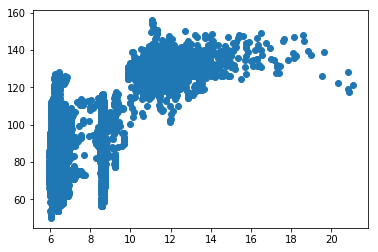

In [6]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
plt.scatter(df1['CAL'], df1['DTC'])

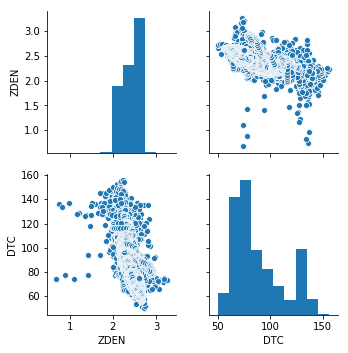

In [7]:
# another library from Seaborn to check the co-linearity
sb.pairplot(df1[['ZDEN', 'DTC']])

## <a>6. Build Machine Learning Models</a>

<a>Top</a>

In [8]:
# seperate the features and targets
df1_data = np.array(df1)
y_trainwell1 = df1_data[:,-2:]
x_trainwell1 = df1_data[:,:-2]

# standize the matrix for training data
scaler = StandardScaler()
x_trainwell1 = scaler.fit_transform(x_trainwell1)

In [9]:
print(y_trainwell1[:5][:])

[[125.9611 306.8676]
 [125.9726 305.8347]
 [125.8528 305.9089]
 [125.7362 305.1737]
 [125.9774 304.4476]]


In [10]:
np.shape(y_trainwell1)

(20525, 2)

In [11]:
# train test split
# please remember to use random_state for all randomization steps, this will ensure we get the same results 
# as yours during the validation phase. 
X_train, X_test, y_train, y_test = train_test_split(x_trainwell1, y_trainwell1, test_size=0.2, random_state=100)


In [12]:
def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [13]:
def result_plot(y_predict, y_real=y_trainwell1):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

0.7101747096879899
Root Mean Square Error is: 21.99087


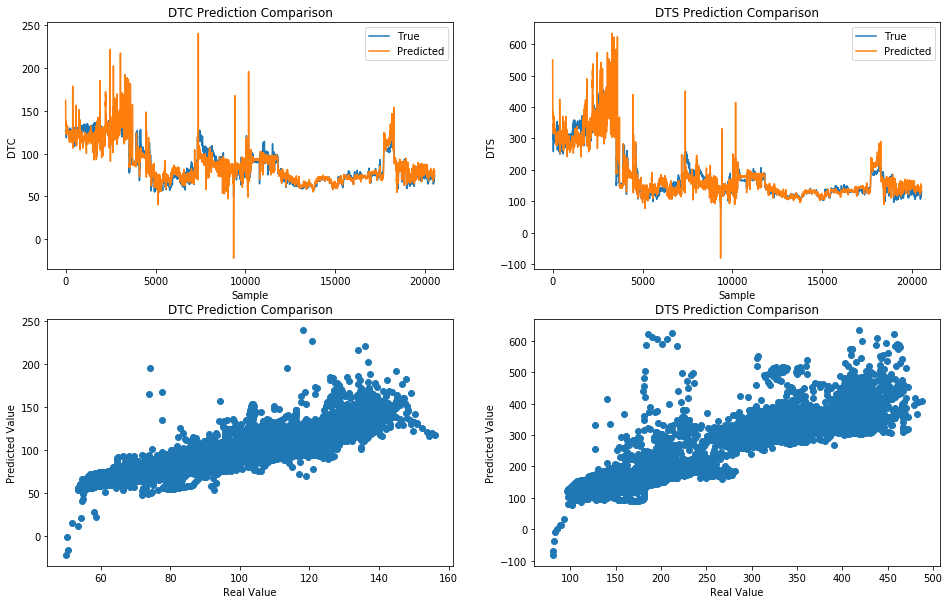

In [14]:
# Linear regression model as the baseline
LR = LinearRegression()
LR_best = grid_search(LR, {})
LR_predict = LR_best.predict(x_trainwell1)
result_plot(LR_predict, y_trainwell1)

Accuracy Score is: 0.87412
Root Mean Square Error is: 21.99087


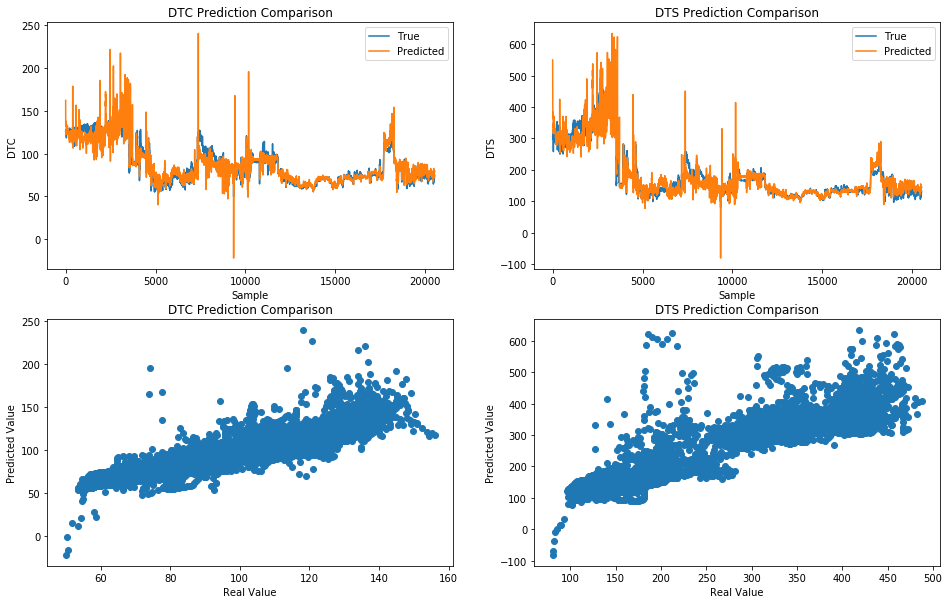

In [15]:
# Add ridge regularization, and see if there's any improvement
ridge = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1], )
ridge.fit(X_train, y_train)
print('Accuracy Score is:', '{:.5f}'.format(ridge.score(X_train, y_train)))
result_plot(ridge.predict(x_trainwell1), y_trainwell1)

0.9875374190713717
Root Mean Square Error is: 3.27980


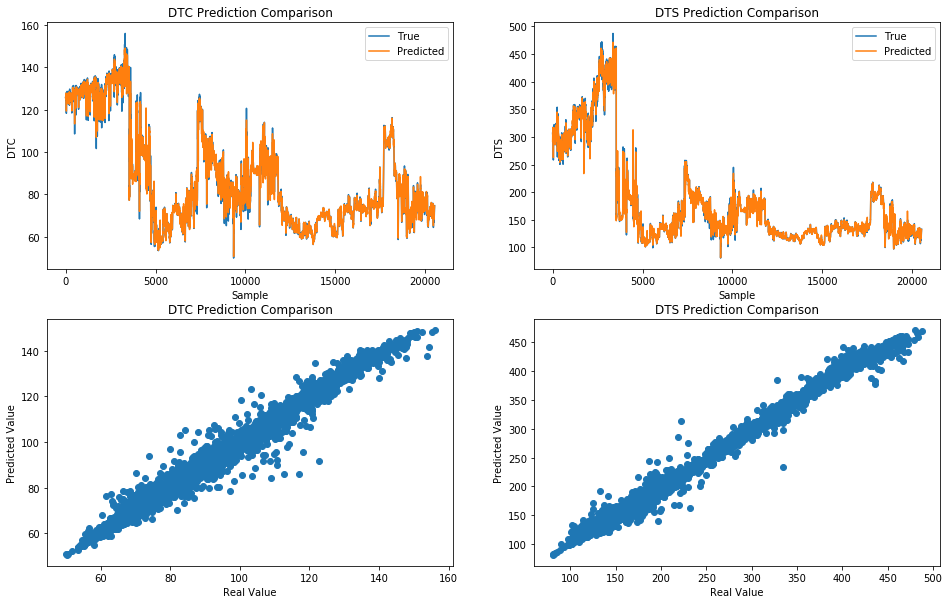

In [16]:
# Random forest model
RF = RandomForestRegressor(n_estimators=100, random_state=100)
RF_best = grid_search(RF, {})
result_plot(RF_best.predict(x_trainwell1), y_trainwell1)

Root Mean Square Error is: 5.76639


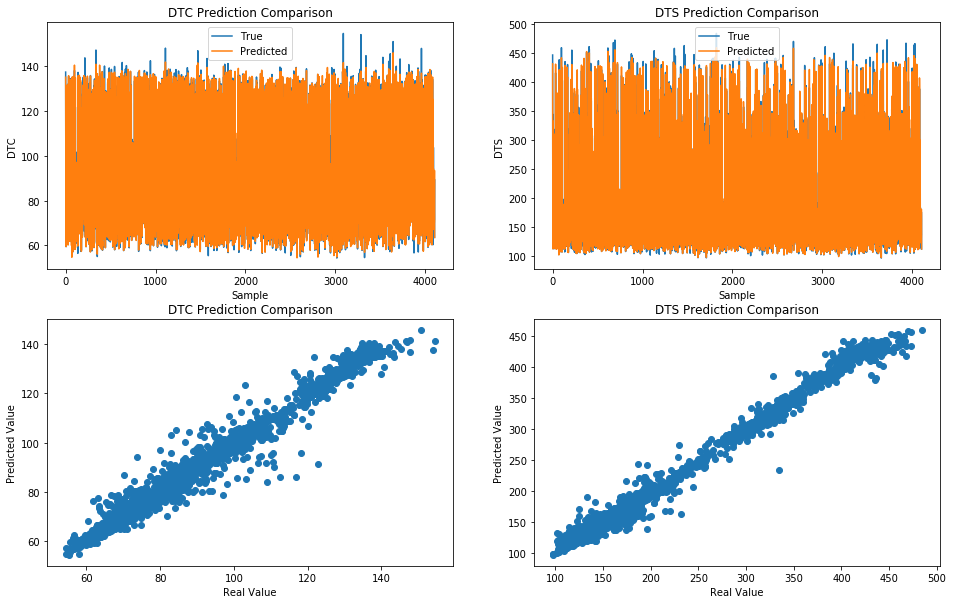

In [17]:
# check the result on test dataset only
result_plot(RF_best.predict(X_test), y_test)

## <a>7. Prediction</a>

<a>Top</a>

In [18]:
# load test data from well 2
df2 = pd.read_csv('test2_19.csv')
# Remove missing 
for col in df2.columns.tolist():
    df2[col][df2[col]==-999] = np.nan
df2.dropna(axis=0, inplace=True)
df2_data = np.array(df2)
x_trainwell2 = df2_data
x_trainwell2 = scaler.transform(x_trainwell2)
#print(y_trainwell2.head())
print(x_trainwell2[:5][:])

[[ 0.08203273  0.02536682  0.09657322 -0.51553228 -0.01196495  0.68453048
  -0.46851864]
 [ 0.08203273  0.02921998  0.12994323 -0.51792726 -0.01198555  0.68016548
  -0.46906897]
 [ 0.08203273  0.03130983  0.16488049 -0.53506725 -0.01214533  0.67253243
  -0.49273318]
 [ 0.07358141  0.03013429  0.13577067 -0.54300242 -0.01226511  0.66003161
  -0.54391391]
 [ 0.08203273  0.02468108  0.05789392 -0.55235151 -0.01236761  0.640949
  -0.61930917]]


In [19]:
# run the prediction
well2_predict = RF_best.predict(x_trainwell2)
well2_predict[:5, :]

array([[100.838968, 210.14813 ],
       [101.221902, 211.240249],
       [102.780163, 213.368357],
       [102.310366, 213.662395],
       [103.985616, 216.006953]])

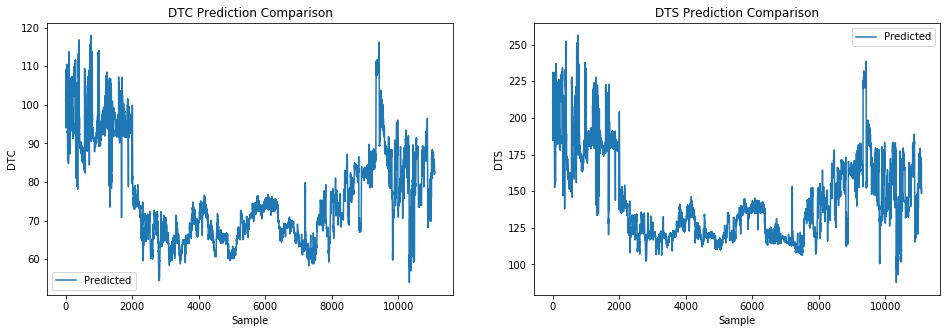

In [20]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_predict[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

In [21]:
output_result = pd.DataFrame({'DTC':well2_predict[:,0], 'DTS':well2_predict[:,1]})
output_result.head()

,DTC,DTS
0,100.838968,210.148130
1,101.221902,211.240249
2,102.780163,213.368357
3,102.310366,213.662395
4,103.985616,216.006953


In [22]:
#output_result.to_csv(path_or_buf='./sample_submission.csv', index=False)
output_result.to_csv(path_or_buf='./sample_submission2_19.csv', index=False)

## <a>8. Summary</a>

<a>Top</a>

Put your ideas, findings, insights, suggestions, and references here